In [1]:
import pandas as pd
import tensorflow as tf
import random
import numpy as np
%pylab inline

/Users/teddy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/Users/teddy/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X_data = pd.read_csv("data/train.csv")
y_data = pd.read_csv("data/test.csv",header=None)
print(X_data.shape)
print(y_data.shape)

(10886, 14)
(10886, 1)


In [3]:
# 2 hidden layers are enough
# parameters
n_hidden_1 = 256
n_hidden_2 = 256
n_input = X_data.shape[1]
n_output = y_data.shape[1]

X = tf.placeholder(tf.float32,[None,n_input],name='X_placeholder')
y = tf.placeholder(tf.float32,[None,n_output],name='y_placeholder')

In [4]:
# define weights and bias
weights = {
    'h1':tf.Variable(tf.random_normal([n_input,n_hidden_1]),name='hidden1'),
    'h2':tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2]),name='hidden2'),
    'output_w':tf.Variable(tf.random_normal([n_hidden_2,n_output]),name='output_w')
}

biases = {
    'b1':tf.Variable(tf.random_normal([n_hidden_1]),name='bias1'),
    'b2':tf.Variable(tf.random_normal([n_hidden_2]),name='bias2'),
    'output_b':tf.Variable(tf.random_normal([n_output]),name='output_b')
}

In [5]:
# get layer
def create_network(X,weights,biases):
    layer1 = tf.add(tf.matmul(X,weights['h1']),biases['b1'],name='layer1')
    layer1 = tf.nn.relu(layer1,name='activ1')
    
    layer2 = tf.add(tf.matmul(layer1,weights['h2']),biases['b2'],name='layer2')
    layer2 = tf.nn.relu(layer2,name='activ2')
    
    out_layer = tf.add(tf.matmul(layer2,weights['output_w']),biases['output_b'],name='output_layer')
    
    return out_layer

In [6]:
# loss and optimizer
pred = create_network(X,weights,biases)

loss = tf.sqrt(tf.reduce_mean(tf.square(pred-y)),name='RMSE') #RMSE
# loss = tf.losses.mean_squared_error(out_layer,y,name='loss_mse') #MSE

optimizer = tf.train.AdagradOptimizer(learning_rate=0.05,name='optimizer').minimize(loss)

In [7]:
%%time
# train
num_case = len(X_data)
epoches = 1000
batch_size = 128
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
#     writer = tf.summary.FileWriter('./graphs/bike',sess.graph)
    
    # train
    for epoch in range(epoches):
        for i in range(0,num_case,batch_size):

            # shuffle the index
            indices = list(range(num_case))
            random.shuffle(indices)
            epoch += 1
            each_loss=0.
            idx = np.array(indices[i:min(i+batch_size, num_case)])
            batch_X = X_data.iloc[idx,:]
            batch_y = y_data.iloc[idx,:]

            _,l = sess.run([optimizer,loss],feed_dict={X:batch_X,y:batch_y})
            each_loss += l
        
        avg_loss = each_loss / int(num_case / batch_size)
        if epoch%100==0:
            print('epoch: #%s : Loss:%.4f'%(epoch,avg_loss))

    pred_value = pred.eval({X:X_data,y:y_data})
    print("The final loss is :%.4f"%avg_loss)

    # tensorboard --logdir /PATH_TO_CODE/runs/1513402825/summaries/

epoch: #100 : Loss:13.3211
epoch: #200 : Loss:4.0464
epoch: #300 : Loss:2.2638
epoch: #400 : Loss:2.0537
epoch: #500 : Loss:3.2726
epoch: #600 : Loss:1.5528
epoch: #700 : Loss:3.5840
epoch: #800 : Loss:2.0144
epoch: #900 : Loss:1.9598
epoch: #1000 : Loss:1.6881
The final loss is :2.1752
CPU times: user 10min 35s, sys: 42.5 s, total: 11min 18s
Wall time: 6min 24s


In [9]:
# validate on itself
RMSE_score = np.sqrt((pow(pred_value-np.array(y_data),2).sum())/len(y_data))
print("RMSE: %.4f"%RMSE_score)

RMSE: 113.7082


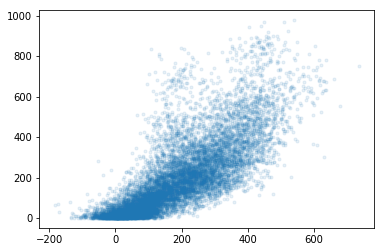

In [10]:
scatter(pred_value[:,0],y_data.values[:,0],marker='.',alpha=.1)